# Earthdata Cloud Exploration: Direct Access and Harmony workflow

## Summary

This notebook will walk through two different access and transformation options across a single dataset available in the Earthdata Cloud: Direct s3 access and Harmony transformation services. These steps are based off of several notebook tutorials presented during the [2021 Earthdata Cloud Hackathon](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/) and [2021 AGU Workshop](https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/). 

The following use case focuses on Sea Surface Temperature (SST) from the GHRSST MODIS L2 dataset (MODIS_T-JPL-L2P-v2019.0) available from PO.DAAC in the Earthdata Cloud.

### Hurricane Ida snapshot

Using [NASA Worldview](https://go.nasa.gov/3nhCwZi), we can first explore SST during a tropical storm event; in this case, we can overlay L2 and L4 SST variables against true color imagery to observe Hurricane Ida in August 2021. Although this is a small sample set, this use case could be expanded to explore how SST responds during the Atlantic hurricane over the next several months. The same data that we are requesting below using direct s3 access and via Harmony-py can also be requested using [NASA Earthdata Search](https://search.earthdata.nasa.gov/search/granules?p=C1940473819-POCLOUD&pg[0][v]=f&pg[0][qt]=2021-08-20T00%3A00%3A00.000Z%2C2021-08-20T23%3A59%3A59.999Z&pg[0][gsk]=-start_date&q=C1940473819-POCLOUD&sb[0]=-97.77667%2C21.20806%2C-83.05197%2C30.16605&tl=1636520265!3!!&m=30.69140625!-97.875!3!1!0!0%2C2) 

![Hurrican Ida snapshot - Worldview](img/Worldview-snapshot-Ida.jpeg)

We will access a single netCDF file from inside the AWS cloud (us-west-2 region, specifically) and load it into Python as an `xarray` `dataset`. This approach leverages S3 native protocols for efficient access to the data.

After inspecting the data, we will then access the same file, but in this case we will also subset the data to our area of interest using Harmony. 

---

## Import Required Packages

In [24]:
# Earthdata Login
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os

# Direct access
import requests
import s3fs
import xarray as xr
import hvplot.xarray

# Harmony
from harmony import BBox, Client, Collection, Request, LinkType
from harmony.config import Environment
from pprint import pprint
import datetime as dt

## 1. Authentication for NASA Earthdata 

_Based off of https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/tutorials/02_NASA_Earthdata_Authentication.html_

First, we will create a hidden `.netrc` file (`_netrc` for Window OS) with Earthdata login credentials in your home directory. This file is needed to access NASA Earthdata assets from a scripting environment like Python.

### Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit <https://urs.earthdata.nasa.gov> to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

### Authentication via netrc File

You will need a netrc file containing your NASA Earthdata Login credentials in order to execute the notebooks. A netrc file can be created manually within text editor and saved to your home directory. An example of the required content is below.

```text
machine urs.earthdata.nasa.gov
login <USERNAME>
password <PASSWORD>
```

`<USERNAME>` and `<PASSWORD>` would be replaced by your actual Earthdata Login username and password respectively.

The code below will:

1. check what operating system (OS) is being used to determine which netrc file to check for/create (.netrc or _netrc)
2. check if you have an netrc file, and if so, varify if those credentials are for the Earthdata endpoint
3. create a netrc file if a netrc file is not present.

In [2]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)

#### See if the file was created

If the file was created, we'll see a `.netrc` file (`_netrc` for Window OS) in the list printed below. To view the contents from a Jupyter environment, click **File** on the top toolbar, select **Open from Path...**, type **.netrc**, and click **Open**. The `.netrc` file will open within the text editor. 

> **!!! Beware,** your password will be visible if the `.netrc` file is opened in the text editor.

In [3]:
!ls -al ~/

total 100
drwxr-xr-x 14 jovyan jovyan  6144 Mar  9 15:11 .
drwxr-xr-x  1 root   root      20 Oct  4 16:21 ..
-rw-------  1 jovyan jovyan 13639 Mar  9 04:48 .bash_history
drwxr-xr-x  9 jovyan jovyan  6144 Dec 15 17:49 .cache
drwxrwsr-x  2 jovyan jovyan  6144 Aug 20  2021 .conda
drwxr-xr-x  4 jovyan jovyan  6144 Oct 29 16:37 .config
-rw-r--r--  1 jovyan jovyan   718 Mar  1 01:30 .dodsrc
-rw-r--r--  1 jovyan jovyan   417 Mar  1 01:31 .edl_cookies
-rw-------  1 jovyan jovyan    69 Mar  9 03:40 .git-credentials
-rw-r--r--  1 jovyan jovyan    84 Nov 15 19:01 .gitconfig
drwxr-xr-x  2 jovyan jovyan  6144 Feb 10 23:32 .ipynb_checkpoints
drwxr-xr-x  5 jovyan jovyan  6144 May 13  2021 .ipython
drwxr-xr-x  3 jovyan jovyan  6144 Jun 23  2021 .jupyter
-rw-r--r--  1 jovyan jovyan     0 May 13  2021 .jupyter-server-log.txt
drwxr-xr-x  3 jovyan jovyan  6144 May 13  2021 .local
-rw-------  1 jovyan jovyan   152 Dec 11 00:09 .netrc
drwx------  2 jovyan jovyan  6144 Dec 14 02:22 .ssh
-rw-r--r--  1 jovyan 

___
## 2. Accessing a NetCDF4/HDF5 File - S3 Direct Access

_Based off of https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/how-tos/Earthdata_Cloud__Single_File__Direct_S3_Access_NetCDF4_Example.html and https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/tutorials/04_On-Prem_Cloud.html_

### Summary

We will access a single netCDF file from the GHRSST MODIS L2 dataset (MODIS_T-JPL-L2P-v2019.0) inside the AWS cloud (us-west-2 region, specifically) and load it into Python as an `xarray` `dataset`. This approach leverages S3 native protocols for efficient access to the data.

### Requirements

#### 1. AWS instance running in us-west-2

NASA Earthdata Cloud data in S3 can be directly accessed via temporary credentials; this access is limited to requests made within the US West (Oregon) (code: us-west-2) AWS region.

#### 2. Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

#### 3. netrc File

You will need a netrc file containing your NASA Earthdata Login credentials in order to execute the notebooks. A netrc file can be created manually within text editor and saved to your home directory. For additional information see: [Authentication for NASA Earthdata](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/04_NASA_Earthdata_Authentication.html#authentication-via-netrc-file).

### Learning Objectives

- how to retrieve temporary S3 credentials for in-region direct S3 bucket access
- how to define a dataset of interest and find netCDF files in S3 bucket
- how to perform in-region direct access of MODIS_T-JPL-L2P-v2019.0 data in S3
- how to plot the data

### Get Temporary AWS Credentials

Direct S3 access is achieved by passing NASA supplied temporary credentials to AWS so we can interact with S3 objects from applicable Earthdata Cloud buckets. For now, each NASA DAAC has different AWS credentials endpoints. Below are some of the credential endpoints to various DAACs:

In [4]:
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
    'gesdisc': 'https://data.gesdisc.earthdata.nasa.gov/s3credentials',
    'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials',
    'ornldaac': 'https://data.ornldaac.earthdata.nasa.gov/s3credentials',
    'ghrcdaac': 'https://data.ghrc.earthdata.nasa.gov/s3credentials'
}

Create a function to make a request to an endpoint for temporary credentials. Remember, each DAAC has their own endpoint and credentials are not usable for cloud data from other DAACs.

In [5]:
def get_temp_creds(provider):
    return requests.get(s3_cred_endpoint[provider]).json()

In [6]:
temp_creds_req = get_temp_creds('podaac')
#temp_creds_req

### Set up an `s3fs` session for Direct Access

`s3fs` sessions are used for authenticated access to s3 buckets and allow for typical file-system style operations. Below we create session by passing in the temporary credentials we recieved from our temporary credentials endpoint.

In [7]:
fs_s3 = s3fs.S3FileSystem(anon=False, 
                          key=temp_creds_req['accessKeyId'], 
                          secret=temp_creds_req['secretAccessKey'], 
                          token=temp_creds_req['sessionToken'],
                          client_kwargs={'region_name':'us-west-2'})

In this example we're interested in the GHRSST MODIS L2 collection from NASA's PO.DAAC in Earthdata Cloud. Below we specify the s3 URL to the data asset in Earthdata Cloud. This URL can be found via [Earthdata Search](https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/tutorials/01_Earthdata_Search.html) or programmatically through the [CMR](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/01_Data_Discovery_CMR.html) and [CMR-STAC](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/02_Data_Discovery_CMR-STAC_API.html) APIs.

In [8]:
short_name = 'MODIS_T-JPL-L2P-v2019.0'
s3_url = 's3://podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0/20210820033500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0.nc'

### Direct In-region Access

Open with the netCDF file using the s3fs package, then load the cloud asset into a concatenated `xarray` `dataset`.

In [9]:
s3_file_obj = fs_s3.open(s3_url, mode='rb')

In [10]:
ssh_ds = xr.open_dataset(s3_file_obj)
ssh_ds

<xarray.Dataset>
Dimensions:                      (nj: 2030, ni: 1354, time: 1)
Coordinates:
    lat                          (nj, ni) float32 ...
    lon                          (nj, ni) float32 ...
  * time                         (time) datetime64[ns] 2021-08-20T03:35:00
Dimensions without coordinates: nj, ni
Data variables:
    sea_surface_temperature      (time, nj, ni) float32 ...
    sst_dtime                    (time, nj, ni) timedelta64[ns] ...
    quality_level                (time, nj, ni) float32 ...
    sses_bias                    (time, nj, ni) float32 ...
    sses_standard_deviation      (time, nj, ni) float32 ...
    l2p_flags                    (time, nj, ni) int16 ...
    sea_surface_temperature_4um  (time, nj, ni) float32 ...
    quality_level_4um            (time, nj, ni) float32 ...
    sses_bias_4um                (time, nj, ni) float32 ...
    sses_standard_deviation_4um  (time, nj, ni) float32 ...
    wind_speed                   (time, nj, ni) float32 ...
    dt_analysis                  (time, nj, ni) float32 ...
Attributes: (12/49)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Terra L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC
    ...                         ...
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Ascending
    endDirection:               Ascending
    day_night_flag:             Night

Let's make a quick plot to take a look at the `sea_surface_temperature` variable.

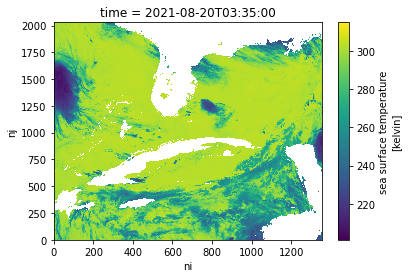

In [11]:
ssh_ds.sea_surface_temperature.plot() ;

---

## 3. Accessing Multiple NetCDF4/HDF5 Files - Data Subsetting and Transformation Services in the Cloud

### Using the Harmony-Py library to access customized data from NASA Earthdata 

#### What other access options or services exist for this dataset?

Maybe we're interested in creating a time series over a larger area or with a larger dataset. Let's see whether there are other services out there that could either make this operation more performant in the cloud (with a cloud-optimized output) or subsetting services to reduce the data volume.

Based off of https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/07_Harmony_Subsetting.html 

### Summary

We have already explored direct access to the NASA EOSDIS archive in the cloud via the Amazon Simple Storage Service (S3) by using the Common Metadata Repository (CMR) to search for granule locations. In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection, and other transformations. 

This tutorial demonstrates how to find, request, and use customized data from a new ecosystem of services operating within the NASA Earthdata Cloud: NASA Harmony.

### Benefits

But first, why use this option when we've already learned how to access data directly from the NASA Earthdata Cloud? 

- Consistent access patterns to EOSDIS holdings make cross-data center data access easier
- Data reduction services allow us to request only the data we want, in the format and projection we want
- Analysis Ready Data and cloud access will help reduce time-to-science
- Community Development helps reduce the barriers for re-use of code and sharing of domain knowledge

See more on the [Earthdata Harmony landing page](https://harmony.earthdata.nasa.gov/), including documentation on the Harmony API itself. 


### Objectives

1. Conceptualize the data transformation service types and offerings provided by NASA Earthdata, including Harmony.
2. Practice skills learned from the introductory CMR tutorial to discover what access and service options exist for a given data set, as well as variable metadata.
3. Utilize the Harmony-py library to request subsetted MODIS L2 Sea Surface Temperature data over the Gulf of Mexico. 
4. Read Harmony subsetted outputs directly into xarray. 

## Discover service options for a given data set

#### _First, what do we mean by a "service"?_

In the context of NASA Earthdata, we are usually referring to a service as any data transformation or customization process that packages or delivers data in a way that makes it easier to work with compared to how the data are natively archived at NASA EOSDIS. Basic customization options may include:
* Subsetting (cropping) the data by:
    * Variable
    * Spatial boundary,
    * Temporal range
* Reformatting
    * For example: From NetCDF-4 to Cloud Optimized GeoTIFF
* Reprojection and/or Resampling
    * For example: From Sinusoidal to Polar Stereographic
* Mosaicking
* Aggregating

A few main types or pathways for services that are commonly supported across the NASA DAACs include:
* [NASA Global Imagery Browse Service](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/gibs)
    * Web services providing imagery, much of which is updated daily, to broaden accessibility of NASA EOSDIS data to the media and public.
* [OPeNDAP](https://opendap.earthdata.nasa.gov/)
    * The Open-source Project for a Network Data Access Protocol is a NASA community standard DAP that provides a simple way to access and work with data over the internet. OPeNDAP's client/server software allows us to subset and reformat data using an internet browser, command line interface, and other applications.
* [Harmony](https://harmony.earthdata.nasa.gov/)
    * In the most basic sense, Harmony is an Application Programming Interface, or API, allowing us to request customization options described above, which are then processed and returned as file outputs. Harmony helps to reduce pre-processing steps so we can spend less time preparing the data, and more time doing science.  

**Note: These service offerings are unique to each NASA EOSDIS dataset.**

Why is this?

Due to varying [levels of service](https://earthdata.nasa.gov/collaborate/new-missions/level-of-service), cloud migration status, and unique characteristics of the datasets themselves, not all service options are provided for all datasets. Therefore it is important to first explore a given dataset's metadata to discover what service options are provided.

#### Note that the full [Harmony tutorial](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/07_Harmony_Subsetting.html) from the 2021 Earthdata Cloud Hackathon demonstrates service and variable discovery, but this was removed here for simplification.

## Using Harmony-Py to subset data

Harmony-Py provides a pip installable Python alternative to directly using Harmony's RESTful API to make it easier to request data and service options, especially when interacting within a Python Jupyter Notebook environment.

The next steps are adopted from the [introduction tutorial](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) notebook provided in the Harmony-Py library:

### Create Harmony Client object
First, we need to create a Harmony Client, which is what we will interact with to submit and inspect a data request to Harmony, as well as to retrieve results.

When creating the Client, we need to provide Earthdata Login credentials, which are required to access data from NASA EOSDIS. This basic line below assumes that we have a `.netrc` available. 

In [12]:
harmony_client = Client()

### Create Harmony Request

The following are common request parameters:

- `collection`: Required parameter. This is the NASA EOSDIS collection, or data product. There are two options for inputting a collection of interest:
    - Provide a concept ID (e.g. C1940473819-POCLOUD)
    - Data product short name (e.g. MODIS_A-JPL-L2P-v2019.0).
- `spatial`: Bounding box spatial constraints on the data. The Harmony Bbox class accepts spatial coordinates as decimal degrees in w, s, e, n order, where longitude = -180, 180 and latitude = -90, 90.
- `temporal`: Date/time constraints on the data. The example below demonstrates temporal start and end ranges using the python datetime library.

As we identified above, only subsetting options are available for this dataset. If other service options such as reformatting are available for a given dataset, these can also be specified using Harmony-py: See the [documentation](https://harmony-py.readthedocs.io/en/latest/) for details on how to construct these parameters.


In [13]:
request = Request(
    collection=Collection(id=short_name),
    spatial=BBox(-97.77667,21.20806,-83.05197,30.16605),
    temporal={
        'start': dt.datetime(2021, 8, 20),
        'stop': dt.datetime(2021, 8, 21),
    },
)

### Submit request

Now that the request is created, we can now submit it to Harmony using the Harmony Client object. A job id is returned, which is a unique identifier that represents the submitted request.

In [14]:
job_id = harmony_client.submit(request)
job_id

'b5c9a494-f428-4a40-a4dc-7b0952e03529'

### Check request status

We can check on the progress of a processing job with status(). This method blocks while communicating with the server but returns quickly.

In [15]:
harmony_client.status(job_id)

{'status': 'running',
 'message': 'The job is being processed',
 'progress': 0,
 'created_at': datetime.datetime(2022, 3, 9, 21, 48, 15, 809000, tzinfo=tzlocal()),
 'updated_at': datetime.datetime(2022, 3, 9, 21, 48, 16, 90000, tzinfo=tzlocal()),
 'created_at_local': '2022-03-09T21:48:15+00:00',
 'updated_at_local': '2022-03-09T21:48:16+00:00',
 'request': 'https://harmony.earthdata.nasa.gov/MODIS_T-JPL-L2P-v2019.0/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat(21.20806%3A30.16605)&subset=lon(-97.77667%3A-83.05197)&subset=time(%222021-08-20T00%3A00%3A00%22%3A%222021-08-21T00%3A00%3A00%22)',
 'num_input_granules': 6}

Depending on the size of the request, it may be helpful to wait until the request has completed processing before the remainder of the code is executed. The wait_for_processing() method will block subsequent lines of code while optionally showing a progress bar.

In [16]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


### View Harmony job response and output URLs
Once the data request has finished processing, we can view details on the job that was submitted to Harmony, including the API call to Harmony, and informational messages on the request if available.

result_json() calls wait_for_processing() and returns the complete job in JSON format once processing is complete. 

In [17]:
data = harmony_client.result_json(job_id)
pprint(data)

{'createdAt': '2022-03-09T21:48:15.809Z',
 'jobID': 'b5c9a494-f428-4a40-a4dc-7b0952e03529',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/stac/b5c9a494-f428-4a40-a4dc-7b0952e03529/',
            'rel': 'stac-catalog-json',
            'title': 'STAC catalog',
            'type': 'application/json'},
           {'bbox': [-95.4, 21.2, -83.1, 30.2],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/podaac/l2-subsetter/c6b98352-ce39-4145-ac6d-973435955217/20210820033500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0_subsetted.nc4',
            'rel': 'data',
            'temporal': {'end': '2021-08-20T03:39:59.000Z',
                         'start': '2021-08-20T03:35:00.000Z'},
            'title': '20210820033500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0_subsetted.nc4',
            'type': 'application/x-netcdf4'},
           {'bbox': [-97.8, 21.2, -94, 30.2],
            'href': 'https://harmony.earthdata.nasa.gov/service-re

### Direct cloud access

Note that the remainder of this tutorial will only succeed when running this notebook within the AWS us-west-2 region.

Harmony data outputs can be accessed within the cloud using the s3 URLs and AWS credentials provided in the Harmony job response.

#### Retrieve list of output URLs.

The result_urls() method calls wait_for_processing() and returns a list of the processed data URLs once processing is complete. You may optionally show the progress bar as shown below.

In [18]:
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
urls = list(results)
pprint(urls)

['s3://harmony-prod-staging/public/podaac/l2-subsetter/c6b98352-ce39-4145-ac6d-973435955217/20210820033500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/c6b98352-ce39-4145-ac6d-973435955217/20210820051501-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/c6b98352-ce39-4145-ac6d-973435955217/20210820154001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/c6b98352-ce39-4145-ac6d-973435955217/20210820154501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/c6b98352-ce39-4145-ac6d-973435955217/20210820172001-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_subsetted.nc4',
 's3://harmony-prod-staging/public/podaac/l2-subsetter/c6b98352-ce39-4145-ac6d-973435955217/20210820172501-JPL-L2P_GHRSST-SSTskin-MODIS_T-D-v02.0-fv01.0_su

We'll select the last URL in the list to bring into xarray below, which matches the granule we opened directly from PO.DAAC's archive bucket above. In [Earthdata Search](https://search.earthdata.nasa.gov/search/granules?p=C1940475563-POCLOUD!C1940475563-POCLOUD&pg[1][v]=t&pg[1][qt]=2021-08-20T00%3A00%3A00.000Z%2C2021-08-20T23%3A59%3A59.999Z&pg[1][gsk]=-start_date&pg[1][m]=download&g=G2107154012-POCLOUD&q=MODIS_T-JPL-L2P-v2019.0&sb[0]=-97.77667%2C21.20806%2C-83.05197%2C30.16605&tl=1646698141!3!!&m=23.509500000000003!-81.99450000000002!4!1!0!0%2C2), we can see that this granule covers our area well.

In [19]:
url = urls[0]
url

's3://harmony-prod-staging/public/podaac/l2-subsetter/c6b98352-ce39-4145-ac6d-973435955217/20210820033500-JPL-L2P_GHRSST-SSTskin-MODIS_T-N-v02.0-fv01.0_subsetted.nc4'

#### AWS credential retrieval
Using aws_credentials you can retrieve the credentials needed to access the Harmony s3 staging bucket and its contents.

In [20]:
creds = harmony_client.aws_credentials()

### Open staged files with *s3fs* and *xarray*

We use the AWS `s3fs` package to create a file system that can then be read by xarray:

In [21]:
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

Now that we have our s3 file system set, including our declared credentials, we'll use that to open the url, and read in the file through xarray. This extra step is needed because xarray cannot open the S3 location directly. Instead, the S3 file object is passed to xarray, in order to then open the dataset. 

In [22]:
f = s3_fs.open(url, mode='rb')
ds = xr.open_dataset(f)
ds

<xarray.Dataset>
Dimensions:                      (nj: 1228, ni: 660, time: 1)
Coordinates:
    lat                          (nj, ni, time) float32 ...
    lon                          (nj, ni, time) float32 ...
  * time                         (time) datetime64[ns] 2021-08-20T03:35:00
Dimensions without coordinates: nj, ni
Data variables:
    sea_surface_temperature      (time, nj, ni) float32 ...
    sst_dtime                    (time, nj, ni) timedelta64[ns] ...
    quality_level                (time, nj, ni) float32 ...
    sses_bias                    (time, nj, ni) float32 ...
    sses_standard_deviation      (time, nj, ni) float32 ...
    l2p_flags                    (time, nj, ni) int16 ...
    sea_surface_temperature_4um  (time, nj, ni) float32 ...
    quality_level_4um            (time, nj, ni) float32 ...
    sses_bias_4um                (time, nj, ni) float32 ...
    sses_standard_deviation_4um  (time, nj, ni) float32 ...
    wind_speed                   (time, nj, ni) float32 ...
    dt_analysis                  (time, nj, ni) float32 ...
Attributes: (12/50)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Terra L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC\n2022-03-09 ...
    ...                         ...
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Ascending
    endDirection:               Ascending
    day_night_flag:             Night
    history_json:               [{"date_time": "2022-03-09T21:48:23.304206+00...

### Plot the data

Use the xarray built in plotting function to create a simple plot along the x and y dimensions of the dataset:

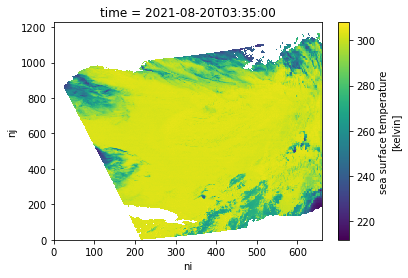

In [23]:
ds.sea_surface_temperature.plot() ;

### Summary

This notebook demonstrated an abbreviated and simplified workflow to explore access and subsetting options available through the Earthdata Cloud. There are several other options that can be used to work "in place" in the Earthdata Cloud, from data discovery to analysis-ready data, including: 

* [Zarr-EOSDIS-Store](https://github.com/nasa/zarr-eosdis-store)
    * The zarr-eosdis-store library allows NASA EOSDIS Collections to be accessed efficiently by the Zarr Python library, provided they have a sidecar DMR++ metadata file generated. 
    * Tutorial highlighting this library's usage: https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/09_Zarr_Access.html 
* [OPeNDAP](https://opendap.earthdata.nasa.gov/) 
    * Hyrax provides direct access to subsetting of NASA data using Python or your favorite analysis tool
    * Tutorial highlighting OPeNDAP usage: https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/06_S6_OPeNDAP_Access_Gridding.html
* [Earthdata Library](https://github.com/nsidc/earthdata)
    * A Python library to search and access NASA Earthdata datasets, aiming to provide a simple way to access or download data without having to worry if a given dataset is on-prem or in the cloud.